# Forecasting the number of patients in ICU due to getting infected by Covid-19

## Abstract

This notebook presents a forecasting model that aims to estimate the number of patients in ICU. It is a project that can be labeled as work-in-progress and is intended to study forecasting modeling under the on-going pandemic aspect. Please pay attention to the disclaimer.

> DISCLAIMER:
>
> Please note this published work is intended for informational purposes only. You may only use the information for your personal and non-commercial use. The opinions expressed in this notebook are those of the author and do not necessarily represent the views and opinions of public officials or the views of any local authorities/authors referred to in this notebook. Although it contains some publicly available information, it does not constitute legal advice about each country's current operative laws and regulations.

Import important modules:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.special import softmax

## Reading Covid dataset

The analysis will be based on the Covid-19 data provided by [Our World in Data](https://github.com/owid).

In [2]:
data_url = (
    "https://raw.githubusercontent.com/"
    "owid/covid-19-data/master/public/data/owid-covid-data.csv"
)
raw_df = pd.read_csv(data_url)
raw_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


Pre-processing dataset:

- Renormalize date to a `datetime` object.
- Reduce the number of columns
- Set date as index
- Drop `NaN`'s
- Fix types for columns

In [3]:
total_df = raw_df.copy()
total_df.date = pd.to_datetime(total_df.date)
total_df = total_df[
    [
        "location",
        "date",
        "total_cases",
        "new_cases",
        "new_cases_smoothed",
        "total_deaths",
        "new_deaths",
        "new_deaths_smoothed",
        "icu_patients",
    ]
]
total_df = total_df.set_index("date")
total_df = total_df.dropna()
total_df = total_df.astype(
    {
        "total_cases": int,
        "new_cases": int,
        "total_deaths": int,
        "new_deaths": int,
        "icu_patients": int,
    }
)
total_df.head()

,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,icu_patients
date,,,,,,,,
2020-04-01,Austria,10711,531,731.857,146,18,16.571,215
2020-04-02,Austria,11129,418,602.857,158,12,15.571,219
2020-04-03,Austria,11524,395,552.429,168,10,15.714,245
2020-04-04,Austria,11781,257,501.429,186,18,16.857,245
2020-04-05,Austria,12051,270,466.143,204,18,16.857,244


## Data exploration



In [4]:
@widgets.interact(
    country=total_df.location.unique(),
    column=[c for c in total_df.columns if c not in ["location", "date"]],
)
def plot_evolution(country, column):
    total_df.loc[total_df.location == country].plot(
        y=column,
        figsize=(15, 5),
        xlim=(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-02-02")),
    )

interactive(children=(Dropdown(description='country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

In [5]:
@widgets.interact(
    country=widgets.Dropdown(options=total_df.location.unique()),
)
def compare_newCases_icu_deaths(country):
    (
        total_df.loc[total_df.location == country]
        .apply(
            lambda x: x / x.max()
            if x.name in {"new_cases_smoothed", "new_deaths_smoothed", "icu_patients"}
            else x
        )
        .plot(
            y=["new_cases_smoothed", "icu_patients", "new_deaths_smoothed"],
            figsize=(15, 5),
            xlim=(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-02-02")),
        )
    )

interactive(children=(Dropdown(description='country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

## Model description

```
+-----------+     +---------------+     +--------+
| New cases | ==> | New ICU cases | ==> | Deaths |
+-----------+     +---------------+     +--------+
```

In the following, we want to develop a model to forecast the number of ICUs based on the number of new cases. We can clearly say that a fraction of new cases will end up needing intensive care. However, we also know that there are a fraction of patients being released. Rather than using mathematical models in epidemiology, we develop a data-driven model to forecast the evolution of the number of ICU patients. 

We start by examining which model we should use even before looking at feature engineering. Our intuition suggests using a linear regression model (or any linear model). We first create a dataset with some features and focus on picking the best performing model before using feature engineering to optimize it.

In [6]:
icu_patients = total_df.loc[
    total_df.location == "Germany",
    ["icu_patients", "new_cases", "new_cases_smoothed"],
]
icu_patients["icu_patients_yesterday"] = icu_patients["icu_patients"].shift(1)
icu_patients = icu_patients.dropna()
icu_patients

,icu_patients,new_cases,new_cases_smoothed,icu_patients_yesterday
date,,,,
2020-03-21,308,2365,2518.286,200.0
2020-03-22,364,2660,2725.429,308.0
2020-03-23,451,4183,3112.000,364.0
2020-03-24,616,3930,3389.857,451.0
2020-03-25,789,4337,3570.857,616.0
...,...,...,...,...
2021-01-30,4342,17518,12460.000,4367.0
2021-01-31,4337,748,11127.143,4342.0
2021-02-01,4313,6668,11095.857,4337.0


## Establishing performance of Regression models 
### Training and tests set for model selection

In [7]:
X_train = icu_patients.loc[:"2021"].drop(["icu_patients"], axis=1)
y_train = icu_patients.loc[:"2021", "icu_patients"]

X_test = icu_patients.loc["2021"].drop(["icu_patients"], axis=1)
y_test = icu_patients.loc["2021":, "icu_patients"]

### Validate models

In [8]:
models = [
    ("LR", LinearRegression()),
    ("RF", RandomForestRegressor()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("EN", ElasticNet()),
    ("LL", LassoLars()),
    ("KN", KNeighborsRegressor()),
    ("MLP", MLPRegressor(max_iter=10_000))
]

results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=2)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring="r2")
    results.append(cv_results)
    names.append(name)
    print(f"{name:>5}: {cv_results.mean():12.2f} ({cv_results.std():.2f})")

   LR:         0.87 (0.05)
   RF:        -0.00 (0.74)
Ridge:         0.87 (0.05)
Lasso:         0.87 (0.05)
   EN:         0.87 (0.05)
   LL:         0.89 (0.08)
   KN:        -3.87 (1.16)
  MLP:         0.85 (0.09)


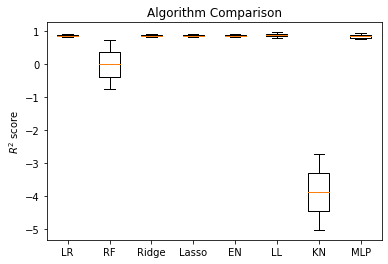

In [9]:
plt.boxplot(results, labels=names)
plt.ylabel("$R^2$ score")
plt.title("Algorithm Comparison");

Comparing the different algorithms, we see that the assumption that linear regression (or a linear model) might be okay holds.

We can now look at the prediction for 2021 and how each model performs precisely.

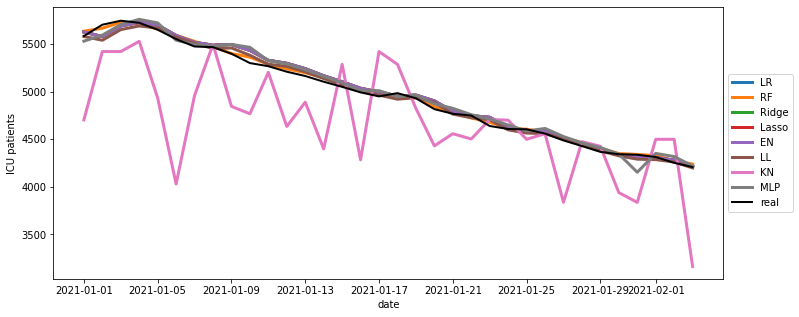

In [10]:
plt.figure(figsize=(12, 5))
for name, model in models:
    plt.plot(
        X_test.index,
        model.fit(X_train, y_train).predict(X_test),
        label=name,
        linewidth=3.0,
    )
plt.plot(y_test, color="k", label="real", linewidth=2.0)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.xlabel("date")
plt.ylabel("ICU patients");

We can see that the different models predict the same outcome for 2021 if we train on the data for 2020, and only KNeighborsRegressor seems to drop off. Nevertheless, we will use `LinearRegression` and examine which feature we need for the best performance.

Indeed, proper normalization might be more useful here, but we continue looking into determining the appropriate features to be used for the prediction.

## Feature engineering

For evaluating the performance for different features, we will have an overview of how the model performs for the beginning of 2021, and then we look at the $r^2$-score of each feature method. Let's define methods to plot the corresponding datasets.

In [11]:
def split_full_dataframe(df):
    """Splits full dataframe into two groups
  
    The whole dataframe `df` is split into two groups with two different dataframes.
    The first group consists of two dataframes until Jan 2021 with training
    data and target data. In contrast, the second group consists of two
    dataframes for validation with test data and corresponding real data.
    """
    X = df.loc[:"2021-01", :].drop("icu_patients", axis=1)
    y = df.loc[:"2021-01", :][["icu_patients"]]

    X_validate = df.loc["2021-01":, :].drop("icu_patients", axis=1)
    y_validate = df.loc["2021-01":, :][["icu_patients"]]

    return X, y, X_validate, y_validate

def train_model(X, y, n_splits, model):
    """Training model
    
    Runs `model.fit` using the training data `X` and target values `y`.
    The model fit is done using cross-validation with time series split
    `TimeSeriesSplit` of sklearn where the argument `n_splits` determines
    the maximum number of splits.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    score = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        score.append(model.score(X_test, y_test))

    return model, score

def model_performance_vis(df, n_splits, model):
    """Train model and visualize results
    
    Take dataframe `df` and split it, then train the model `model` using
    `n_splits`-splits for cross-validation. Afterwards use visulize the
    data with the left plot showing the predicted and the real number of ICU
    patients and the right showing the feature importance.
    """
    X, y, X_validate, y_validate = split_full_dataframe(df)
    model, score = train_model(X, y, n_splits, model)

    y_validate["icu_predicted"] = model.predict(X_validate)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

    y_validate.plot.line(
        y=["icu_patients", "icu_predicted"],
        ax=ax1,
        ylabel="ICU patients",
    )
    ax1.legend(["Real", "Predicted"])

    feature_values = softmax(np.abs(model.coef_[0]))
    sorted_indices = feature_values.argsort()
    feature_names = np.array(X.columns)

    ax2.barh(
        np.arange(len(feature_values)), feature_values[sorted_indices], align="center"
    )
    ax2.set_xlim(0, 1.0)
    ax2.set_xticks(np.linspace(0, 1.0, 6))
    ax2.set_xticklabels([f"{int(100 * f)} %" for f in np.linspace(0, 1.0, 6)])
    ax2.set_xlabel("Relative importance")
    ax2.set_yticks(range(len(feature_names)))
    ax2.set_yticklabels(feature_names[sorted_indices])
    fig.tight_layout()

def evaluate_feature_selection(
    feature_selection_method,
    full_df, 
    model=LinearRegression(),
):
    """Visualize feature selection interactively
    
    Function for creating two widgets, a dropdown with country selection
    and a slider with selecting number of cross-validation splits.
    """
    @widgets.interact(
        country=widgets.Dropdown(
            options=full_df.location.unique(),
            description="Country"
        ),
        n_splits=widgets.IntSlider(
            value=5,
            min=2,
            max=24,
            description="CV splits",
            orientation="horizontal",
        ),
    )
    def country_selection(country, n_splits):
        df = feature_selection_method(full_df[full_df.location == country])
        model_performance_vis(df, n_splits, model)

### Method 1

Features are:

- `new_cases`: number of new Covid-19 cases

In [12]:
def method_1(df):
    """1: new cases"""
    return df.loc[:, ["icu_patients", "new_cases"]]

evaluate_feature_selection(method_1, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 2

Features are:

- `new_cases`: number of new Covid-19 cases
- `new_cases_smoothed`: number of new Covid-19 cases (smooth)

In [13]:
def method_2(df):
    """2: new cases + smoothed"""
    return df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]

evaluate_feature_selection(method_2, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 3

Features are:

- `new_cases`: number of new Covid-19 cases
- `new_cases_smoothed`: number of new Covid-19 cases (smooth)
- `icu_-1d`: number of ICU patient of previous day

In [14]:
def method_3(df):
    """3: new cases + smoothed + ICU (-1d)"""
    df = df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df = df.dropna()
    return df

evaluate_feature_selection(method_3, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 4

Features are:

- `new_cases`: number of new Covid-19 cases
- `new_cases_smoothed`: number of new Covid-19 cases (smooth)
- `icu_-1d`: number of ICU patient of previous day
- `icu_-1d_diff`: change of number of ICU patient of previous day

In [15]:
def method_4(df):
    """4: new cases + smoothed + ICU (-1d) + ∆ICU(-1d)"""
    df = df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff()
    df = df.dropna()
    return df

evaluate_feature_selection(method_4, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 5

Features are:

- `new_cases`: number of new Covid-19 cases
- `new_cases_smoothed`: number of new Covid-19 cases (smooth)
- `icu_-1d`: number of ICU patient of previous day
- `icu_-1d_diff`: change of number of ICU patient of previous day (smooth)

In [16]:
def method_5(df):
    """5: new cases + smoothed new + ICU (-1d) + ∆ICU(-1d) smooth"""
    df = df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_5, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 6

Features are:

- `new_cases_smoothed`: number of new Covid-19 cases (smooth)
- `icu_-1d`: number of ICU patient of previous day
- `icu_-1d_diff`: change of number of ICU patient of previous day (smooth)

In [17]:
def method_6(df):
    """6: smoothed new + ICU(-1d) + ∆ICU(-1d)"""
    df = df.loc[:, ["icu_patients", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_6, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 7

Features are:

- `new_cases_smoothed`: number of new Covid-19 cases (smooth)
- `icu_-1d`: number of ICU patient of previous day
- `icu_-1d_diff`: change of number of ICU patient of previous day (smooth)
- `icu_-2d`: number of ICU patient from 2 days ago
- `icu_-2d_diff`: change of number of ICU patient from 2 days ago (smooth)

In [18]:
def method_7(df):
    """7: smoothed new + ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df.loc[:, ["icu_patients", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_7, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 8

Features are:

- `new_cases_-7d`: number of new Covid-19 cases 7 days ago
- `new_cases_smoothed`: number of new Covid-19 cases (smooth)
- `icu_-1d`: number of ICU patient of previous day
- `icu_-1d_diff`: change of number of ICU patient of previous day (smooth)
- `icu_-2d`: number of ICU patient from 2 days ago
- `icu_-2d_diff`: change of number of ICU patient from 2 days ago (smooth)

In [19]:
def method_8(df):
    """8: smoothed new + new(-7d) + ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df.loc[:, ["icu_patients", "new_cases_smoothed"]]
    df["new_cases_-7d"] = df["new_cases_smoothed"].shift(7)
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_8, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Method 9

- `icu_-1d`: number of ICU patient of previous day
- `icu_-1d_diff`: change of number of ICU patient of previous day (smooth)
- `icu_-2d`: number of ICU patient from 2 days ago
- `icu_-2d_diff`: change of number of ICU patient from 2 days ago (smooth)

In [20]:
def method_9(df):
    """9: ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df.loc[:, ["icu_patients"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_9, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

### Comparision of each model against each other

In the following we want to look at all the methods and how they perform against for various countries.

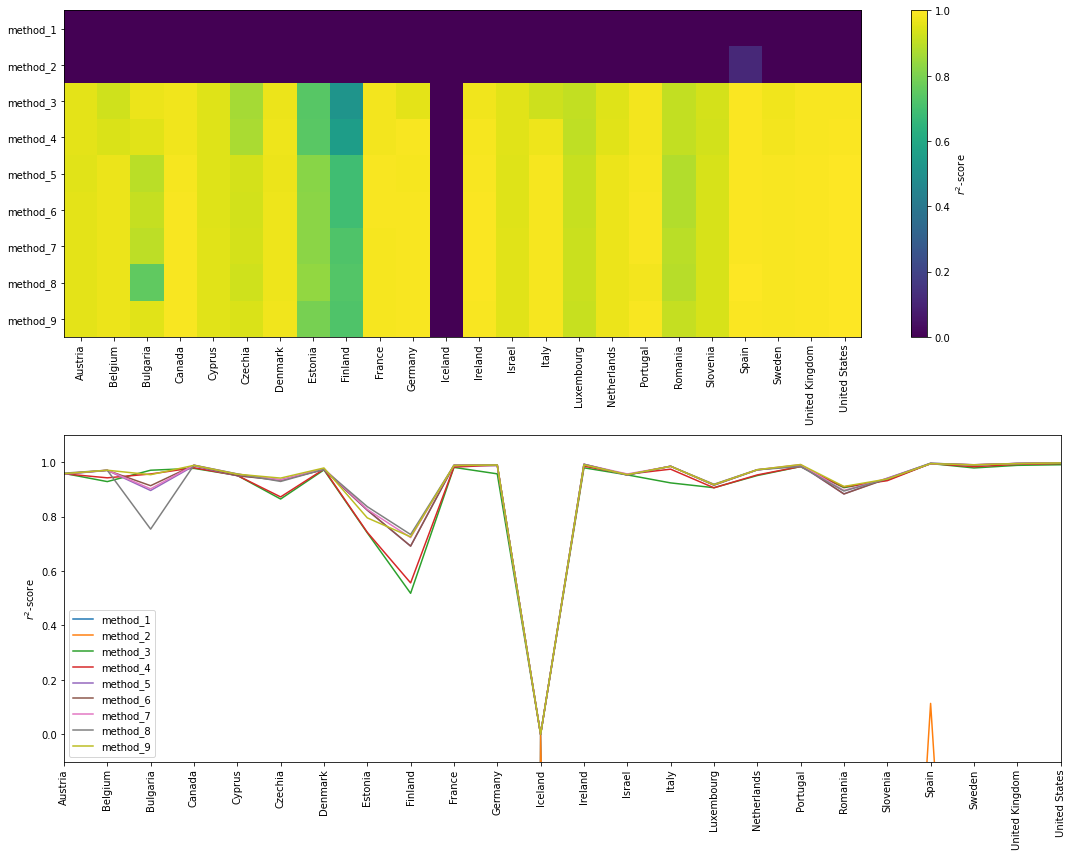

In [21]:
def prepare_training_data(df):
    # split train and validate where 2021 is the border
    train = df[:"2020-12"]
    validate = df["2021-01":]
    return (
        train.drop("icu_patients", axis="columns"),
        train[["icu_patients"]],
        validate.drop("icu_patients", axis="columns"),
        validate[["icu_patients"]],
    )

countries = total_df.location.unique()
feature_methods = [v for k, v in dict(globals()).items() if k.startswith("method_")]
feature_names = [
    v.__name__ for k, v in dict(globals()).items() if k.startswith("method_")
]
number_of_splits = 6

performance = np.zeros((len(countries), len(feature_methods)))

for i, country in enumerate(countries):
    for j, method in enumerate(feature_methods):
        df = method(total_df[total_df.location == country])
        X, y, X_validate, y_validate = prepare_training_data(df)
        model, _ = train_model(X, y, number_of_splits, LinearRegression())

        performance[i, j] = model.score(X_validate, y_validate).mean()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 12))

# 2d plot
m = ax1.imshow(performance.T, aspect="auto", vmin=0.0, vmax=1.0)
ax1.set_xticks(range(len(countries)))
ax1.set_xticklabels(countries, rotation="vertical")
ax1.set_yticks(range(len(feature_names)))
ax1.set_yticklabels(feature_names)
cbar = plt.colorbar(m, ax=ax1)
cbar.set_label("$r^2$-score")

# lineouts
for i, perf in enumerate(performance.T):
    ax2.plot(perf, label=feature_names[i])

ax2.legend()
ax2.set_xlim(0, len(performance)-1)
ax2.set_xticks(range(len(countries)))
ax2.set_xticklabels(countries, rotation="vertical")
ax2.set_ylim(-0.1, 1.1)
ax2.set_ylabel("$r^2$-score")
fig.tight_layout()

For certain countries, like Iceland, forecasting the number of ICU patients was not possible. Iceland did not have any patients in ICUs (for the period of validation), and our model can not capture this. However, we have to include the patients in ICUs from the previous days to forecast the ICU number correctly. Features based on method 7 seem to perform best. There is one caveat with including the number of ICUs of the previous days as a feature. As we previously described, the number of ICUs depends on the number of new cases, but we have seen that our model does not consider this and tries to predict the number of ICUs based on the number of ICUs of the previous days. It does not break causality, as the number of new cases and the change is encoded in the number of ICUs. In the following, we want to look at a model which uses only the number of cases from the day before and new cases.

## Forecasting ICUs

In [22]:
options_for_countries = [
    'Austria',
    'Belgium',
    'Bulgaria',
    'Canada',
    'Cyprus',
    'Czechia',
#     'Denmark',
    'Estonia',
#     'Finland',
    'France',
    'Germany',
#     'Iceland',
#     'Ireland',
#     'Israel',
    'Italy',
    'Luxembourg',
    'Netherlands',
    'Portugal',
#     'Romania',
#     'Slovenia',
#     'Spain',
    'Sweden',
    'United Kingdom',
    'United States',
]

#### Different slider for changing prediction parameters
country_selection = widgets.Dropdown(
    options=options_for_countries,
    description="Country",
)
growth_factor = widgets.SelectionSlider(
    options=(0.1 / (1 + np.exp(-np.linspace(-6, 6, 1001)))) + 0.95,
    index=1,
    description="Factor",
)
growth_exponent = widgets.FloatSlider(
    min=0,
    max=3,
    value=3,
    description="Exponent",
)
prediction_beginning = widgets.SelectionRangeSlider(
    options=pd.date_range(start="2020-06-02", end="2021-01-31"),
    index=(0, 200),
    readout=False,
    description="Date",
)


#### Functions for data pipeline
def main_feature_extraction(df):
    return df[["icu_patients", "new_cases_smoothed"]]

def feature_renaming(df):
    return df.rename(
        columns={
            "new_cases_smoothed": "new_cases",
            "icu_patients": "icu"
        }
    )
    
def feature_engineering(df):
    df = df.copy()
    df["icu_yesterday"] = df["icu"].shift(1)
    return df.dropna()

def feature_target_split(df):
    features = df.drop(columns="icu")
    target = df[["icu"]]
    return features, target

#### Forecast the ICU numbers
def perform_forecasting(df, model, starting, ending):
    prediction_period = pd.date_range(start=starting, end=ending)
    one_day = prediction_period.freq
    
    assert df.index[-1] > prediction_period[-1]

    # predict for the next day
    for day in prediction_period[:-1]:
        X = (
            df.loc[day, ["new_cases_sim", "icu_yesterday"]]
            .to_numpy()
            .reshape(1, -1)
        )
        df.loc[day, "icu_sim"] = model.predict(X)[0]
        # fixing boundary
        df.loc[day + one_day, "icu_sim"] = np.nan
        df.loc[day + one_day, "icu_yesterday"] = df.loc[day, "icu"]
        
    return df


#### Prediction of ICU patients
@widgets.interact(
    country=country_selection,
    factor=growth_factor,
    exponent=growth_exponent,
    dates=prediction_beginning,
)
def icu_prediction(country, factor, exponent, dates):
    df = (
        total_df[total_df.location == country]
        .pipe(main_feature_extraction)
        .pipe(feature_renaming)
        .pipe(feature_engineering)
    )
    
    start, end = dates
    
    # for simulation train over whole dataset
    X, y = feature_target_split(df)
    icu_forecast_model, _ = train_model(X, y, n_splits=3, model=LinearRegression())
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))

    df["new_cases_sim"] = df["new_cases"].copy()
    df["icu_sim"] = df["icu"].copy()

    # new cases simulated
    x = np.arange(len(df.loc[start:, "new_cases_sim"]))
    df.loc[start:, "new_cases_sim"] = df.loc[start, "new_cases_sim"] * factor ** (exponent * x)
    
    # perform forecasting
    df = perform_forecasting(df, icu_forecast_model, start, end)

    # plot new cases/new cases simulated
    df[:start].new_cases.plot.line(ax=ax1, color="k", label="Previous")
    df[start:].new_cases.plot.line(ax=ax1, color="0.8", label="Real")
    df[start:end].new_cases_sim.plot.line(ax=ax1, color="C3", label="Simulated")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("New cases")
    ax1.legend()
    
    # plot icu cases
    df[:start].icu.plot.line(ax=ax2, color="k", label="Previous")
    df[start:].icu.plot.line(ax=ax2, color="0.8", label="Real")
    df[start:end].icu_sim.plot.line(ax=ax2, color="C3", label="Predicted")
    ax2.set_xlabel("Date")
    ax2.set_ylabel("Number of ICUs")
    ax2.legend()

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

If we look at the forecasting, then we see for a simulated case, our model only follows the trend dictated by the number of ICUs of the previous day and can recover an unlikely trend. There are two aspects to consider here:

- Training is done on the whole set, and is the model forecasting is not done on the previous data, which can lead to high variance and overfitting
- As previously discussed, the number of ICUs in the past is not a good measure to be considered in this study

## Conclusion

We have shown the first steps to develop a forecasting model for the number of patients in ICUs. We have seen that forecasting based on only the new cases as a feature does not lead to a reasonable $r^2$-score. In future work, we have to examine if maybe going further back in the past in terms of new cases as a feature might lead to better scores. The use of the number of ICUs should be excluded as a feature of the model. It would prevent fitting to this feature.